## Анализ эффективности маркетинговой кампании

In [1]:
import numpy as np
import pandas as pd
import kagglehub
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import plotly.express as px

Даны **два датасета**, в которых представлены результаты А/В эксперимента. Будем считать, что выборки сформированы случайным образом и эксперимент проведен корректно (в одинаковых условиях для обеих групп). В датасетах посчитаны метрики, показывающие эффективность двух маркетинговых кампаний (тестовой и контрольной). Необходимо определить, **насколько тестовая кампания эффективнее или не эффективнее контрольной**.

### 1. Предварительная обработка данных

In [2]:
# Загружаю датасет
path = kagglehub.dataset_download("amirmotefaker/ab-testing-dataset")
print("Path to dataset files:", path)

Path to dataset files: /Users/kirill/.cache/kagglehub/datasets/amirmotefaker/ab-testing-dataset/versions/1


In [3]:
# Формирую тестовую и контрольную группы
control = pd.read_csv(path + '/control_group.csv', sep=';')
test = pd.read_csv(path + '/test_group.csv', sep=';')

In [4]:
control.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Campaign Name        30 non-null     object 
 1   Date                 30 non-null     object 
 2   Spend [USD]          30 non-null     int64  
 3   # of Impressions     29 non-null     float64
 4   Reach                29 non-null     float64
 5   # of Website Clicks  29 non-null     float64
 6   # of Searches        29 non-null     float64
 7   # of View Content    29 non-null     float64
 8   # of Add to Cart     29 non-null     float64
 9   # of Purchase        29 non-null     float64
dtypes: float64(7), int64(1), object(2)
memory usage: 2.5+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Campaign Name        30 non-null     object
 1   Date                 30 non-null     object
 2   Spend [USD]          30 non-null     int64 
 3   # of Impressions     30 non-null     int64 
 4   Reach                30 non-null     int64 
 5   # of Website Clicks  30 non-null     int64 
 6   # of Searches        30 non-null     int64 
 7   # of View Content    30 non-null     int64 
 8   # of Add to Cart     30 non-null     int64 
 9   # of Purchase        30 non-null     int64 
dtypes: int64(8), object(2)
memory usage: 2.5+ KB


In [6]:
# Формирую один датасет для последующего расчета метрик
total = pd.concat([control, test])

In [7]:
# Форматирую колонки для удобства
total = total.rename(columns={'Campaign Name': 'Campaign_Name',
                                  'Spend [USD]':'Spend_USD',
                                  '# of Impressions':'n_of_Impressions',
                                  '# of Website Clicks': 'n_of_Website_Clicks',
                                  '# of Searches':'n_of_Searches',
                                  '# of View Content':'n_of_View_Content',
                                  '# of Add to Cart':'n_of_Add_to_Cart',
                                  '# of Purchase': 'n_of_Purchase'})

In [8]:
# Привожу дату в корректный формат, а также немного форматирую итоговой датасет
total.Date = pd.to_datetime(total.Date, format = '%d.%m.%Y')
total = total.sort_values(by = 'Date').reset_index()
del total['index']

In [9]:
# Смотрим итоговый датасет
total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Campaign_Name        60 non-null     object        
 1   Date                 60 non-null     datetime64[ns]
 2   Spend_USD            60 non-null     int64         
 3   n_of_Impressions     59 non-null     float64       
 4   Reach                59 non-null     float64       
 5   n_of_Website_Clicks  59 non-null     float64       
 6   n_of_Searches        59 non-null     float64       
 7   n_of_View_Content    59 non-null     float64       
 8   n_of_Add_to_Cart     59 non-null     float64       
 9   n_of_Purchase        59 non-null     float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 4.8+ KB


In [10]:
# В отдельных столбцах есть пропущенные значения
total.isnull().sum()

Campaign_Name          0
Date                   0
Spend_USD              0
n_of_Impressions       1
Reach                  1
n_of_Website_Clicks    1
n_of_Searches          1
n_of_View_Content      1
n_of_Add_to_Cart       1
n_of_Purchase          1
dtype: int64

In [11]:
# Найдем строку с пропущенными значениями. 
total[total.isnull().any(axis=1)]

,Campaign_Name,Date,Spend_USD,n_of_Impressions,Reach,n_of_Website_Clicks,n_of_Searches,n_of_View_Content,n_of_Add_to_Cart,n_of_Purchase
8,Control Campaign,2019-08-05,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Это 5 августа 2019 года. Уберем эту дату из тестирования для корректности резульататов
total = total.query('Date != "2019-08-05"')

In [13]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58 entries, 0 to 59
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Campaign_Name        58 non-null     object        
 1   Date                 58 non-null     datetime64[ns]
 2   Spend_USD            58 non-null     int64         
 3   n_of_Impressions     58 non-null     float64       
 4   Reach                58 non-null     float64       
 5   n_of_Website_Clicks  58 non-null     float64       
 6   n_of_Searches        58 non-null     float64       
 7   n_of_View_Content    58 non-null     float64       
 8   n_of_Add_to_Cart     58 non-null     float64       
 9   n_of_Purchase        58 non-null     float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 5.0+ KB


### 2. Определение целевых и прокси метрик для анализа эффективности маркетинговых кампаний

##### Целевые метрики:  
1. Стоимость привлечения пользователя (общие затраты на кампанию / количество покупок)
2. Конверсия в оплату (покупки/охват)


##### Прокси метрики:  
1. Общее число кликов
2. Число пользователей, добавивших товар в корзину
3. Промежуточные коневрсии (Показы - Клики, Клики - Просмотр контента, Просмотры - добавление в корзину)

In [14]:
# Для тестовой и контрольной группы считаем метрики для последующего подсчета конверсионных метрик
metrics = total.groupby(['Campaign_Name'], as_index=False) \
     .agg({'Spend_USD':'sum',
           'n_of_Impressions':'sum',
           'Reach':'sum',
           'n_of_Website_Clicks':'sum',
           'n_of_Searches':'sum',
           'n_of_View_Content':'sum',
           'n_of_Add_to_Cart':'sum',
           'n_of_Purchase':'sum'})

In [15]:
metrics

,Campaign_Name,Spend_USD,n_of_Impressions,Reach,n_of_Website_Clicks,n_of_Searches,n_of_View_Content,n_of_Add_to_Cart,n_of_Purchase
0,Control Campaign,66818,3177233.0,2576503.0,154303.0,64418.0,56370.0,37700.0,15161.0
1,Test Campaign,74595,2123249.0,1509609.0,175107.0,70463.0,54882.0,25490.0,14869.0


In [16]:
# Рассчитываем целевые и вспомогательные конверсионные метрики
metrics['CR_pay'] = metrics.n_of_Purchase / metrics.n_of_Impressions * 100 # конверсия из показов рекламы в покупку
metrics['CR_cart_to_pay'] = metrics.n_of_Purchase / metrics.n_of_Add_to_Cart * 100 # конверсия из показов рекламы в покупку
metrics['CR_cart'] = metrics.n_of_Add_to_Cart / metrics.n_of_View_Content * 100 # конверсия из просмотра контента в добавление в корзину
metrics['CR_view'] = metrics.n_of_View_Content / metrics.n_of_Searches * 100 # конверсия из поиска на сайте в просмотр контента
metrics['CR_search'] = metrics.n_of_Searches / metrics.n_of_Website_Clicks * 100 # конверсия из кликов в поиск на сайте
metrics['CTR'] = metrics.n_of_Website_Clicks / metrics.n_of_Impressions * 100 # конверсия из показов объявлений в клики на сайте
metrics['CPA'] = metrics.Spend_USD / metrics.n_of_Purchase # стоимость привлечения клиента
metrics['n_not_Purchase'] = metrics.n_of_Impressions - metrics.n_of_Purchase # количество не перешедших в покупку пользователей

In [17]:
metrics

,Campaign_Name,Spend_USD,n_of_Impressions,Reach,n_of_Website_Clicks,n_of_Searches,n_of_View_Content,n_of_Add_to_Cart,n_of_Purchase,CR_pay,CR_cart_to_pay,CR_cart,CR_view,CR_search,CTR,CPA,n_not_Purchase
0,Control Campaign,66818,3177233.0,2576503.0,154303.0,64418.0,56370.0,37700.0,15161.0,0.477176,40.214854,66.879546,87.506598,41.747730,4.856521,4.407229,3162072.0
1,Test Campaign,74595,2123249.0,1509609.0,175107.0,70463.0,54882.0,25490.0,14869.0,0.700295,58.332679,46.445100,77.887686,40.239968,8.247125,5.016814,2108380.0


### 3. А/В тестирование целевых метрик (CR_pay, количество покупок)

#### 3.1. Конверсия в покупку

In [18]:
# Выведем значение метрики конверсия в покупку в тестовой и контрольной группах
CR_pay = metrics[['Campaign_Name','CR_pay']]
CR_pay

,Campaign_Name,CR_pay
0,Control Campaign,0.477176
1,Test Campaign,0.700295


In [19]:
# Посчитаем на сколько изменилась метрика в тестовой группе
CR_pay = metrics[['Campaign_Name','CR_pay']]
CR_control = CR_pay.query('Campaign_Name == "Control Campaign"').CR_pay.iloc[0]
CR_test = CR_pay.query('Campaign_Name == "Test Campaign"').CR_pay.iloc[0]
percent_of_change = round((CR_test - CR_control) / CR_control * 100,2)

In [20]:
print(f"Значение конверсии в тестовой группе увеличилось на {percent_of_change}%.") 

Значение конверсии в тестовой группе увеличилось на 46.76%.


После подсчета метрик видно, что значение конверсии *увеличилось*. Необходимо проверить результат с помощью **АБ тестирования**.  

Для начала сформулируем **гипотезы**:  
$H0$ - значения конверсии в тестовой и контрольной группах равны  
$H1$ - значения конверсии в тестовой и контрольной группах отличаются

Определим **уровень значимости** (вероятность отклонить нулевую гипотезу, если она верна, то есть **ошибки первого рода**):   
$\alpha = 0.05$

In [21]:
# Составим таблицу сопряженности
chi_test_cr_pay = metrics[['n_of_Purchase', 'n_not_Purchase']]
chi_test_cr_pay

,n_of_Purchase,n_not_Purchase
0,15161.0,3162072.0
1,14869.0,2108380.0


In [22]:
#Используем критерий Хи-квадрат, для определения статзначимости различий между выборками
stat, p, dof, expected = st.chi2_contingency(chi_test_cr_pay)
print(f"Значение статистики = {stat:.4f}")
print(f"p-value = {p:.4f}")
print(f"Степени свободы = {dof}")
print("Ожидаемые значения:\n", expected)

Значение статистики = 1124.2950
p-value = 0.0000
Степени свободы = 1
Ожидаемые значения:
 [[  18000.68503015 3159232.31496985]
 [  12029.31496985 2111219.68503015]]


По результатам теста $p-value < \alpha$ **(равен нулю)**.  
Есть основания отвергнуть нулевую гипотезу.  
**Конверсия в покупку в тестовой группе увеличилась** (исходя из данных на 46%)

#### 3.2. Стоимость привлечения

In [23]:
total['CPA'] = total.Spend_USD/total.n_of_Purchase

In [24]:
CPA = total.groupby('Campaign_Name', as_index=False).agg({'CPA':'mean'})

In [25]:
CPA

,Campaign_Name,CPA
0,Control Campaign,5.052339
1,Test Campaign,5.999890


In [26]:
count_control= CPA.query('Campaign_Name == "Control Campaign"').CPA.iloc[0]
count_test = CPA.query('Campaign_Name == "Test Campaign"').CPA.iloc[0]
percent_per_count = round(abs((count_test - count_control) / count_test * 100),2)

In [27]:
print(f"Стоимость привлечения пользователей в тестовой группе увеличилось на {percent_per_count}%.") 

Стоимость привлечения пользователей в тестовой группе увеличилось на 15.79%.


Сформулируем **гипотезы**:  
$H0$ - CPA в тестовой и контрольной группах равны  
$H1$ - CPA тестовой и контрольной группах отличаются

Определим **уровень значимости** (вероятность отклонить нулевую гипотезу, если она верна, то есть **ошибки первого рода**):   
$\alpha = 0.05$

Исследуем значения в двух выборках (проверим данные на аномалии, **нормальность** и **равенство дисперсий**)

In [28]:
CPA_control = total.query('Campaign_Name == "Control Campaign"').CPA
CPA_test = total.query('Campaign_Name == "Test Campaign"').CPA

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


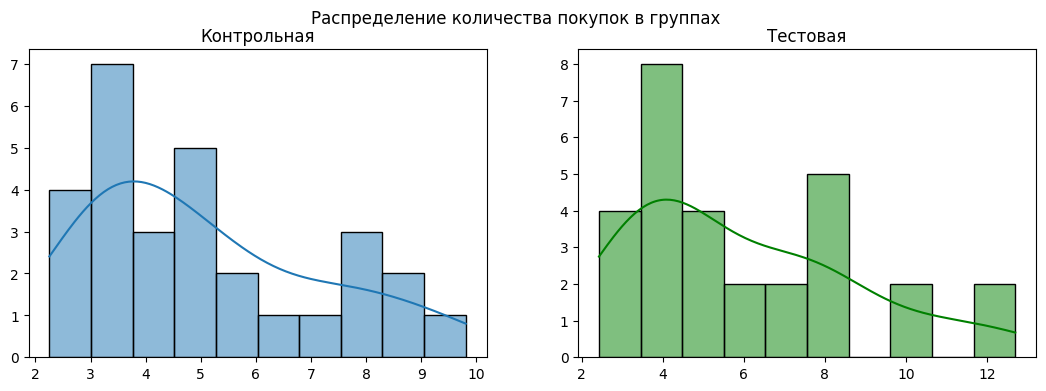

In [29]:
# Посмотрим на распределение и аномалии в данных
plt.figure(figsize=(13,4))
plt.suptitle('Распределение количества покупок в группах')

plt.subplot(1,2,1)
plt.title('Контрольная')
sns.histplot(data = CPA_control, bins=10, kde=True)
plt.xlabel('')
plt.ylabel('')

plt.subplot(1,2,2)
plt.title('Тестовая')
sns.histplot(data = CPA_test, color='g', bins=10, kde=True)
plt.xlabel('')
plt.ylabel('')

plt.show()

Проверим данные на **нормальность**

In [30]:
# Используем метод Шапиро-Уилка для небольших выборок
pg.normality(data = total, dv = 'CPA', group='Campaign_Name', method='shapiro')

,W,pval,normal
Campaign_Name,,,
Control Campaign,0.913187,0.020563,False
Test Campaign,0.902387,0.011180,False


Визуально оценим нормальность распределения выборок c помощью QQ-графиков

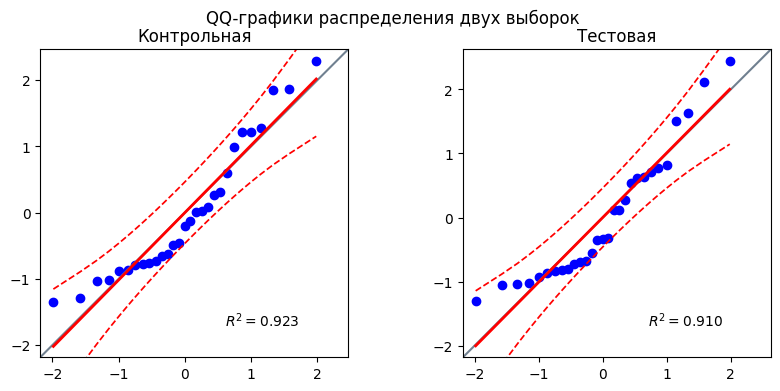

In [31]:
plt.figure(figsize=(10,4))
plt.suptitle('QQ-графики распределения двух выборок')

plt.subplot(1,2,1)
pg.qqplot(CPA_control)
plt.title('Контрольная')
plt.xlabel('')
plt.ylabel('')

plt.subplot(1,2,2)
pg.qqplot(CPA_test)
plt.title('Тестовая')
plt.xlabel('')
plt.ylabel('')

plt.show()

Ненормальностью тестовой выборки можно принебречь, так как распределение **умеренно отличается от нормального**, а также при таком объеме выборки будет применятся **центральная предельная теорема**.

In [32]:
# Проверим равенство дисперсий выборок
pg.homoscedasticity(data = total, dv = 'CPA', group='Campaign_Name', method='levene')

,W,pval,equal_var
levene,1.683778,0.199743,True


Так как дисперсии равны, а характер распределения нормальный (одна выборка близка к нормальному распределению) можно использовать **Т-тест Стьюдента** для проверки статзначимости различий между группами

In [33]:
pg.ttest(CPA_control, CPA_test, correction=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.45533,52.171876,two-sided,0.151569,"[-2.25, 0.36]",0.382188,0.641,0.29856


По результатам теста $p-value > \alpha$ **(0.151569)**.  
Нет оснований отвергнуть нулевую гипотезу.  
**CPA не изменилось**

### 4. Описательный анализ вспомогательных метрик

#### 4.1. Воронка действий пользователя

Необходимо понять на каком этапе взаимодействия с продуктом **"отваливается" больше всего пользователей** и как отличаются данные показатели в тестовой и контрольной группах. Для этого необходимо провести **анализ воронки действий пользователя**, для чего у нас есть все необходимые метрики. 

In [35]:
metrics

,Campaign_Name,Spend_USD,n_of_Impressions,Reach,n_of_Website_Clicks,n_of_Searches,n_of_View_Content,n_of_Add_to_Cart,n_of_Purchase,CR_pay,CR_cart_to_pay,CR_cart,CR_view,CR_search,CTR,CPA,n_not_Purchase
0,Control Campaign,66818,3177233.0,2576503.0,154303.0,64418.0,56370.0,37700.0,15161.0,0.477176,40.214854,66.879546,87.506598,41.747730,4.856521,4.407229,3162072.0
1,Test Campaign,74595,2123249.0,1509609.0,175107.0,70463.0,54882.0,25490.0,14869.0,0.700295,58.332679,46.445100,77.887686,40.239968,8.247125,5.016814,2108380.0


Создадим отдельные датасеты для **количественных** и **конверсионных** метрик

In [54]:
# Конверсионные метрики по этапам
CR_metrics = metrics[['CTR','CR_search','CR_view','CR_cart','CR_cart_to_pay', 'CR_pay']]

In [59]:
# Количественные метрики по этапам
count_metrics = metrics[['n_of_Impressions', 'n_of_Website_Clicks','n_of_Searches','n_of_View_Content','n_of_Add_to_Cart','n_of_Purchase']]

In [60]:
# Преобразуем таблицу в читаемый вид. А также посчитаем, на сколько процентов изменилась метрика в тестовой группе
count_metrics = count_metrics.transpose().rename(columns = {0:'Контрольная',
                                            1:'Тестовая'},
                                 index = {'n_of_Impressions':'Показы',
                                          'n_of_Website_Clicks':'Клики',
                                          'n_of_Searches':'Поисковые запросы',
                                          'n_of_View_Content':'Просмотры',
                                          'n_of_Add_to_Cart':'Добавления в корзину',
                                          'n_of_Purchase':'Покупки'})
count_metrics['Процент изменения'] = round((count_metrics['Тестовая'] - count_metrics['Контрольная']) / count_metrics['Контрольная'] * 100, 2)

In [61]:
# То же самое для конверсионных метрик
CR_metrics = CR_metrics.transpose().rename(columns = {0:'Контрольная',
                                         1:'Тестовая'},
                              index = {'CTR':'Конверсия из показов в клики',
                                       'CR_search':'Конверсия из кликов в поисковые запросы',
                                       'CR_view':'Конверсия из поисковых запросов в просмотры',
                                       'CR_cart':'Конверсия из просмотров в добавление в корзину',
                                       'CR_cart_to_pay':'Конверсия из корзины в покупки',
                                       'CR_pay':'Конверсия из показов в покупки'}).round(2)
CR_metrics['Процент изменения'] = round((CR_metrics['Тестовая'] - CR_metrics['Контрольная']) / CR_metrics['Контрольная'] * 100, 2)

In [72]:
count_metrics

,Контрольная,Тестовая,Процент изменения,% Контрольная
Показы,3177233.0,2123249.0,-33.17,100.00
Клики,154303.0,175107.0,13.48,4.86
Поисковые запросы,64418.0,70463.0,9.38,2.03
Просмотры,56370.0,54882.0,-2.64,1.77
Добавления в корзину,37700.0,25490.0,-32.39,1.19
Покупки,15161.0,14869.0,-1.93,0.48


In [71]:
count_metrics['% Контрольная'] = (count_metrics['Контрольная'] / count_metrics['Контрольная'].iloc[0] * 100).round(2)

In [42]:
CR_metrics

,Контрольная,Тестовая,Процент изменения
Конверсия из показов в клики,4.86,8.25,69.75
Конверсия из кликов в поисковые запросы,41.75,40.24,-3.62
Конверсия из поисковых запросов в просмотры,87.51,77.89,-10.99
Конверсия из просмотров в добавление в корзину,66.88,46.45,-30.55
Конверсия из корзины в покупки,40.21,58.33,45.06
Конверсия из показов в покупки,0.48,0.70,45.83


На основе количественных метрик, построим **воронку действий пользователя** в тестовой и контрольной группах. 

In [66]:
# Для удобства отображения на графике создадим отдельный датафрейм, 
# в котором будут данные обо всех количественных метриках в двух группах
df_1 = count_metrics[['Контрольная']]
df_1['Группа'] = 'Контрольная'
df_1 = df_1.rename(columns={'Контрольная':'Значение'})

df_2 = count_metrics[['Тестовая']]
df_2['Группа'] = 'Тестовая'
df_2 = df_2.rename(columns={'Тестовая':'Значение'})

df=pd.concat([df_1, df_2], axis=0)

/var/folders/br/yryz75s94419__57gscfgy900000gn/T/ipykernel_6267/103755812.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/br/yryz75s94419__57gscfgy900000gn/T/ipykernel_6267/103755812.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



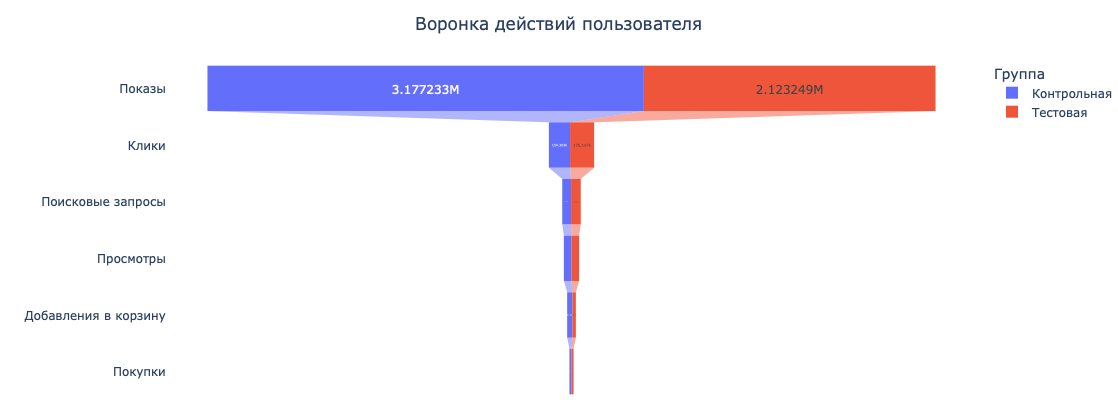

In [68]:
fig = px.funnel(df, 
                x=df['Значение'], 
                y=df.index,
                color = 'Группа')

fig.update_layout(width=1000, 
                  height=400,
                  xaxis_title = '',
                  yaxis_title = '',
                  margin=dict(l=0, r=0, t=60, b=0),
                  plot_bgcolor="white", 
                  paper_bgcolor="white",
                  title=dict(text="Воронка действий пользователя",
                             x=0.5 ,
                             xanchor='center'))

fig.update_traces(hovertemplate="",
                  textposition = 'inside')

fig.update_yaxes(showticklabels=True)

fig.show()